<a href="https://colab.research.google.com/github/Hamedamz/MIDOG/blob/main/notebooks/MIDOG_Hamed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIDOG Challenge

This is an example notebook for the [MIDOG Challenge](https://imi.thi.de/midog/) to support you in your first steps with the data. First, general data analysis is presented, and then a RetinaNet is trained on the data. The data is loaded from a shared google drive folder. 

To see the code please **double click** on the cells. 

All relevant variables for the notebook are [form parameters](https://colab.research.google.com/notebooks/forms.ipynb). We encourage you to play around with the parameters like source and target scanner or learning rate values. 

In [1]:
#title Import some python packages { vertical-output: true, display-mode: "form" }

%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install -U plotly

import json
from pathlib import Path
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from tqdm import tqdm
import pandas as pd
import random
import cv2

In [2]:
#title Mount MIDOG Data { run: "auto", vertical-output: true, display-mode: "both" }

#markdown - **First**: Please, open the following link in a new tab [MIDOG data](https://drive.google.com/drive/folders/1YUMKNkXUtgaFM6jCHpZxIHPZx_CqE_qG?usp=sharing) 
#markdown - **Second**: Create a shortcut in your personal drive folder
#markdown ![Alt-Text](https://drive.google.com/uc?export=view&id=1PqdHF3F586ALVbL414-wQH81e1dPXdbg)
#markdown - **Finally**: Set the folder path to your mounted MIDOG data location in your google drive folder and run this cell. 


from google.colab import drive
drive.mount('/drive')

#markdown **Note**: When you try to mount Google Drive for the first time, you will have to provide Google Drive with access rights. For this, click on the link that is shown, approve the request and enter the authentification code.

#markdown If you don't want to do so, you may instead download the notebook under File -> Download

folder = "MyDrive/MIDOG_Challenge" #param {type:"string"}
midog_folder = Path("/drive") / Path(folder)

#markdown Your output should contain **MIDOG.sqlite** and **MIDOG.json**:
print(list(midog_folder.glob("*.*")))

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
[PosixPath('/drive/MyDrive/MIDOG_Challenge/MIDOG.sqlite'), PosixPath('/drive/MyDrive/MIDOG_Challenge/MIDOG.json')]


In [3]:
#title ## Install requirements  to handle whole slide images { vertical-output: true }

#markdown - !pip install object-detection-fastai
#markdown - Linux: !apt-get install python3-openslide
#markdown - Windows: https://openslide.org/download/


!apt-get install python3-openslide
from openslide import open_slide

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-openslide is already the newest version (1.1.1-2ubuntu4).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


## Object detection library and data exploration

For object detection on whole slide images (WSI), we use code from this  https://github.com/ChristianMarzahl/ObjectDetection repository.
If you are using the repository or parts thereof, please cite the corresponding [paper](https://www.nature.com/articles/s41598-020-65958-2):

```
@article{marzahl2020deep,
  title={Deep learning-based quantification of pulmonary hemosiderophages in cytology slides},
  author={Marzahl, Christian and Aubreville, Marc and Bertram, Christof A and Stayt, Jason and Jasensky, Anne-Katherine and Bartenschlager, Florian and Fragoso-Garcia, Marco and Barton, Ann K and Elsemann, Svenja and Jabari, Samir and Jens, Krauth and Prathmesh, Madhu and Jörn, Voigt and Jenny, Hill and Robert, Klopfleisch and Andreas, Maier },
  journal={Scientific Reports},
  volume={10},
  number={1},
  pages={1--10},
  year={2020},
  publisher={Nature Publishing Group}
}
```

In [4]:
#title Install the object detection library { run: "auto", vertical-output: true, display-mode: "form" }

!pip install -U object-detection-fastai

from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBMetrics, PascalVOCMetricByDistance, PascalVOCMetric, PascalVOCMetricByDistance

In [5]:
#title Let us take a look at the files. { display-mode: "form" }

#markdown Scanner:
#markdown - Hamamatsu XR: File 001.tif to 050.tif
#markdown - Hamamatsu S360: File 051.tif to 100.tif
#markdown - Aperio CS2: File 101.tif to 150.tif
#markdown - Leica GT450: File 151.tif to 200.tif (No annotations)
#markdown
#markdown **Note**: The images from the Leica GT450 are not accompanied by annotations.


image_folder = midog_folder / "images"

hamamatsu_rx_ids = list(range(0, 51))
hamamatsu_360_ids = list(range(51, 101))
aperio_ids = list(range(101, 151))
leica_ids = list(range(151, 201))

In [6]:
#title Loading the annotations and converting them to a Pandas DataFrame for easier handling and visualisation. { vertical-output: true, display-mode: "form" }


#markdown **Note**: In the ground truth data, the classes are called **not mitotic figure** and **mitotic figure**. In the following, we will use the labels **hard negative** and **mitotic figure** to make the notebook clearer.  


annotation_file = midog_folder / "MIDOG.json"
rows = []
with open(annotation_file) as f:
    data = json.load(f)

    #categories = {cat["id"]: cat["name"] for cat in data["categories"]}
    categories = {1: 'mitotic figure', 2: 'hard negative'}

    for row in data["images"]:
        file_name = row["file_name"]
        image_id = row["id"]
        width = row["width"]
        height = row["height"]

        scanner  = "Hamamatsu XR"
        if image_id in hamamatsu_360_ids:
            scanner  = "Hamamatsu S360"
        if image_id in aperio_ids:
            scanner  = "Aperio CS"
        if image_id in leica_ids:
            scanner  = "Leica GT450"
         
        for annotation in [anno for anno in data['annotations'] if anno["image_id"] == image_id]:
            box = annotation["bbox"]
            cat = categories[annotation["category_id"]]

            rows.append([file_name, image_id, width, height, box, cat, scanner])

df = pd.DataFrame(rows, columns=["file_name", "image_id", "width", "height", "box", "cat", "scanner"])
df.head()

file_name  image_id  width  height                             box  \
0  001.tiff         1   7215    5412          [4336, 346, 4386, 396]   
1  001.tiff         1   7215    5412            [756, 872, 806, 922]   
2  001.tiff         1   7215    5412          [270, 4044, 320, 4094]   
3  001.tiff         1   7215    5412  [6672.5, 706.5, 6722.5, 756.5]   
4  002.tiff         2   7215    5412          [1872, 319, 1922, 369]   

             cat       scanner  
0  hard negative  Hamamatsu XR  
1  hard negative  Hamamatsu XR  
2  hard negative  Hamamatsu XR  
3  hard negative  Hamamatsu XR  
4  hard negative  Hamamatsu XR

### Statistics
The following examples will give you an idea regarding the distribution of mitotic figure annotations and hard examples in the data across the different scanners.

#### **Please be aware that only the mitotic figures are relevant for the challenge.**
The hard negatives (non-mitotic cell) annotations are only meant to visualise the problem.



In [7]:
# #title The ration of mitotic figure vs hard negative annotations. { display-mode: "form" }

# pie_df = pd.DataFrame([
#           ["mitotic figure", len(df[df["cat"] == "mitotic figure"])],
#           ["hard negative", len(df[df["cat"] == "hard negative"])]], columns=["cat", "total"])

# fig = px.pie(pie_df, values='total', names='cat', title='Mitotic figures vs hard negatives')
# fig.show()

In [8]:
# #title Number of mitotic figure vs not mitotic figures per scanner and image { display-mode: "form" }


# for scanner in df['scanner'].unique():

#     scanner_annos = df[df['scanner'] == scanner]

#     row = []
#     for image_id in scanner_annos["image_id"].unique():
#         image_annos = scanner_annos[scanner_annos["image_id"] == image_id]
#         row.append([image_id, len(image_annos[image_annos['cat'] == 'mitotic figure']), "mitotic figure"])
#         row.append([image_id, len(image_annos[image_annos['cat'] == 'hard negative']), "hard negative"])

#     scanner_meta = pd.DataFrame(row, columns=["image_id", "total", "type"])

#     fig = px.bar(scanner_meta, x="image_id", y="total", color="type", title=f"{scanner}: Annotations per image")
#     fig.show()

### Visual Examples

In [9]:
# #title Example scanner images to visualise the domain shift. { run: "auto", display-mode: "form" }
# num_images_per_scanner = 10 #param {type:"integer"}
# thumbail_size =  512#param {type:"integer"}

# for scanner, ids in zip(["Hamamatsu XR", "Hamamatsu S360", "Aperio CS2", "Leica GT450"], [hamamatsu_rx_ids, hamamatsu_360_ids, aperio_ids, leica_ids]):

#     imgs = []

#     for image_id in tqdm(ids[:num_images_per_scanner]):

#         image_id += 1

#         file_path = image_folder / f"{image_id:03d}.tiff"

#         if file_path.exists():
#             slide = open_slide(str(file_path))
#             img = slide.get_thumbnail((thumbail_size, thumbail_size))
#             imgs.append(np.array(img))

#     imgs = np.array(imgs)

#     max_x = max([img.shape[1] for img in imgs])
#     max_y = max([img.shape[0] for img in imgs])

#     imgs = np.array([cv2.resize(img, dsize=(max_x, max_y)) for img in imgs])

#     fig = px.imshow(imgs, facet_col=0, facet_col_wrap=5, labels={'facet_col':'Image'}, title=scanner)

#     for i, id in enumerate(ids[:num_images_per_scanner]):
#         fig.layout.annotations[i]['text'] = f'Image: {id}'

#     fig.show()

In [10]:
# #title Take a look a the annotations for one file. Red boxes show mitotic figures while blue boxes represent hard negatives. Please use the slider to view different images.  { run: "auto", display-mode: "form" }
# thumbail_size_big = 1024 #param {type:"integer"}

# #random.choice(hamamatsu_rx_ids)
# image_id = 113  #param {type:"slider", min:1, max:200, step:1}

# slide = open_slide(str(image_folder / f"{image_id:03d}.tiff"))

# image = slide.get_thumbnail((thumbail_size_big, thumbail_size_big))

# fig = px.imshow(image)

# scale_x = slide.level_dimensions[0][0] / image.size[0]
# scale_y = slide.level_dimensions[0][1] / image.size[1]

# for id, anno in df[df["image_id"] == image_id].iterrows():

#     x0, y0, x1, y1 = anno.box[0] / scale_x, anno.box[1] / scale_y, anno.box[2] / scale_x, anno.box[3] / scale_y


#     fig.add_shape(
#         type='rect',
#         x0=x0, x1=x1, y0=y0, y1=y1,
#         xref='x', yref='y',
#         line_color='red' if "mitotic" in anno["cat"] else "blue"
#     )

# fig.update_layout(
#     autosize=False,
#     width=image.size[0],
#     height=image.size[1],
#     )

# fig.show()

In [11]:
# #title Extracted examples for mitotic figures.  { run: "auto", display-mode: "form" }
# num_mitotic_figures_per_scanner = 10  #param {type:"integer"}

# for scanner, ids in zip(["Hamamatsu XR", "Hamamatsu S360", "Aperio CS2"], [hamamatsu_rx_ids, hamamatsu_360_ids, aperio_ids]):

#     imgs = []

#     for image_id in tqdm(ids):

#         image_id += 1

#         file_path = image_folder / f"{image_id:03d}.tiff"

#         if file_path.exists():
#             slide = open_slide(str(file_path))
#             annotations = df[(df["file_name"] == f"{image_id:03d}.tiff") & (df["cat"] =="mitotic figure" )]

#             for id, anno in annotations.iterrows():

#                 center_x, center_y = anno.box[0] + (anno.box[2] - anno.box[0]) / 2, anno.box[1] + (anno.box[3] - anno.box[1]) / 2
#                 img = np.array(slide.read_region((int(center_x-50), int(center_y-50)), level=0, size=(100, 100)))
#                 imgs.append(img)

#                 if len(imgs) == num_mitotic_figures_per_scanner:
#                     break

#         if len(imgs) == num_mitotic_figures_per_scanner:
#             break

#     fig = px.imshow(np.array(imgs), facet_col=0, facet_col_wrap=5, labels={'facet_col':'mitotic figure'}, title=scanner)
#     fig.show()

In [12]:
# #title Extracted examples for hard negatives.  { run: "auto", display-mode: "form" }
# num_mitotic_figures_per_scanner = 10  #param {type:"integer"}

# for scanner, ids in zip(["Hamamatsu XR", "Hamamatsu S360", "Aperio CS2"], [hamamatsu_rx_ids, hamamatsu_360_ids, aperio_ids]):

#     imgs = []

#     for image_id in tqdm(ids):

#         image_id += 1

#         file_path = image_folder / f"{image_id:03d}.tiff"

#         if file_path.exists():
#             slide = open_slide(str(file_path))
#             annotations = df[(df["file_name"] == f"{image_id:03d}.tiff") & (df["cat"] == "hard negative" )]

#             for id, anno in annotations.iterrows():

#                 center_x, center_y = anno.box[0] + (anno.box[2] - anno.box[0]) / 2, anno.box[1] + (anno.box[3] - anno.box[1]) / 2
#                 img = np.array(slide.read_region((int(center_x-50), int(center_y-50)), level=0, size=(100, 100)))
#                 imgs.append(img)

#                 if len(imgs) == num_mitotic_figures_per_scanner:
#                     break

#         if len(imgs) == num_mitotic_figures_per_scanner:
#             break

#     fig = px.imshow(np.array(imgs), facet_col=0, facet_col_wrap=5, labels={'facet_col':'hard negative'}, title=scanner)
#     fig.show()

# Finally some object detection!

After we have had a look at the data, we now want to guide you towards detecting mitotic figures using an object detection approach. Before we can train the object detection network, we need to set up the training procedure.

In [13]:
#title Sampling functions: { display-mode: "both" }

#markdown The sampling function defines from which position on the high power field (HPF) a patch should be extracted for training and validation. This function is needed because HPFs are too big to fit into memory (RAM and VRAM), and therefore we randomly sample patches. 

def sample_function(y, classes, size, level_dimensions, level):
    width, height = level_dimensions[level]
    if len(y[0]) == 0:
        return randint(0, width - size[0]), randint(0, height -size[1])
    else:
        #if randint(0, 5) < 2:
        if True:
            class_id = np.random.choice(classes, 1)[0] # select a random class
            ids = np.array(y[1]) == class_id # filter the annotations according to the selected class
            xmin, ymin, _, _ = np.array(y[0])[ids][randint(0, np.count_nonzero(ids) - 1)] # randomly select one of the filtered annotatons as seed for the training patch
            
            # To have the selected annotation not in the center of the patch and an random offset.
            xmin += random.randint(-size[0]/2, size[0]/2) 
            ymin += random.randint(-size[1]/2, size[1]/2)
            xmin, ymin = max(0, int(xmin - size[0] / 2)), max(0, int(ymin -size[1] / 2))
            xmin, ymin = min(xmin, width - size[0]), min(ymin, height - size[1])
            return xmin, ymin
        else:
            return randint(0, width - size[0]), randint(0, height -size[1])

In [14]:
#title Select a training and validation scanner { run: "auto", display-mode: "form" }

def create_wsi_container(annotations_df: pd.DataFrame):

    container = []

    for image_name in tqdm(annotations_df["file_name"].unique()):

        image_annos = annotations_df[annotations_df["file_name"] == image_name]

        bboxes = [box   for box   in image_annos["box"]]
        labels = [label for label in image_annos["cat"]]

        container.append(SlideContainer(image_folder/image_name, y=[bboxes, labels], level=res_level,width=patch_size, height=patch_size, sample_func=sample_function))

    return container

#markdown Options can also be combined like:  Hamamatsu XR, Hamamatsu S360
train_scanner = "Hamamatsu XR" #param ["Hamamatsu XR", "Hamamatsu S360", "Aperio CS"]  {allow-input: true}
val_scanner = "Hamamatsu S360" #param ["Hamamatsu XR", "Hamamatsu S360", "Aperio CS"]  {allow-input: true}

patch_size = 256 #param [256, 512, 1024]
res_level = 0

train_annos = df[df["scanner"].isin(train_scanner.split(","))]
train_container = create_wsi_container(train_annos)

val_annos = df[df["scanner"].isin(val_scanner.split(","))]
valid_container = create_wsi_container(val_annos)

f"Created: {len(train_container)} training WSI container and {len(valid_container)} validation WSI container"

100%|██████████| 50/50 [00:00<00:00, 87.54it/s]


'Created: 50 training WSI container and 50 validation WSI container'

In [15]:
train_2_scanner = "Aperio CS" #param ["Hamamatsu XR", "Hamamatsu S360", "Aperio CS"]  {allow-input: true}

train_2_annos = df[df["scanner"].isin(train_2_scanner.split(","))]
train_2_container = create_wsi_container(train_2_annos)

100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


In [16]:
#title Just 50 images are too few for big batch sizes, so lets increase the number by random sampling { run: "auto" }

import numpy as np
train_samples_per_scanner = 1500 #param {type:"integer"}
val_samples_per_scanner = 500 #param {type:"integer"}

train_images = list(np.random.choice(train_container, train_samples_per_scanner))
train_2_images = list(np.random.choice(train_2_container, train_samples_per_scanner))
valid_images = list(np.random.choice(valid_container, val_samples_per_scanner))

In [17]:
#title We build on the [FastAI](https://www.fast.ai/) pipline. Please take a look a the [documentation](https://docs.fast.ai/) for more information. { run: "auto", display-mode: "form" }

batch_size = 12 #param {type:"integer"}

#markdown Lets add some basic data [augmentation](https://docs.fast.ai/vision.augment.html)
do_flip = True #param {type:"boolean"}
flip_vert = True #param {type:"boolean"}
max_rotate = 90 #param {type:"number"}
max_zoom = 1.1 #param {type:"number"}
max_lighting = 0.2 #param {type:"number"}
max_warp = 0.2 #param {type:"number"}
p_affine = 0.75 #param {type:"number"}
p_lighting = 0.75 #param {type:"number"}



tfms = get_transforms(do_flip=do_flip,
                      flip_vert=flip_vert,
                      max_rotate=max_rotate,
                      max_zoom=max_zoom,
                      max_lighting=max_lighting,
                      max_warp=max_warp,
                      p_affine=p_affine,
                      p_lighting=p_lighting)

train, valid = ObjectItemListSlide(train_images), ObjectItemListSlide(valid_images)
item_list = ItemLists(".", train, valid)
lls = item_list.label_from_func(lambda x: x.y, label_cls=SlideObjectCategoryList)
lls = lls.transform(tfms, tfm_y=True, size=patch_size)
data = lls.databunch(bs=batch_size, collate_fn=bb_pad_collate,num_workers=0).normalize()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


In [18]:
train_2 = ObjectItemListSlide(train_2_images)
item_list_2 = ItemLists(".", train_2, valid)
lls_2 = item_list_2.label_from_func(lambda x: x.y, label_cls=SlideObjectCategoryList)
lls_2 = lls_2.transform(tfms, tfm_y=True, size=patch_size)
data_2 = lls_2.databunch(bs=batch_size, collate_fn=bb_pad_collate,num_workers=0).normalize()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [19]:
# #title Show some training data example patches. { run: "auto", display-mode: "form" }

# rows = 3 #param {type:"integer"}
# figsize = 12 #param {type:"integer"}
# data.show_batch(rows=rows, ds_type=DatasetType.Train, figsize=(figsize, figsize))

In [20]:
# #title Show some validation data example patches. { run: "auto", display-mode: "form" }

# rows = 3 #param {type:"integer"}
# figsize = 12 #param {type:"integer"}

# data.show_batch(rows=rows, ds_type=DatasetType.Valid, figsize=(figsize, figsize))

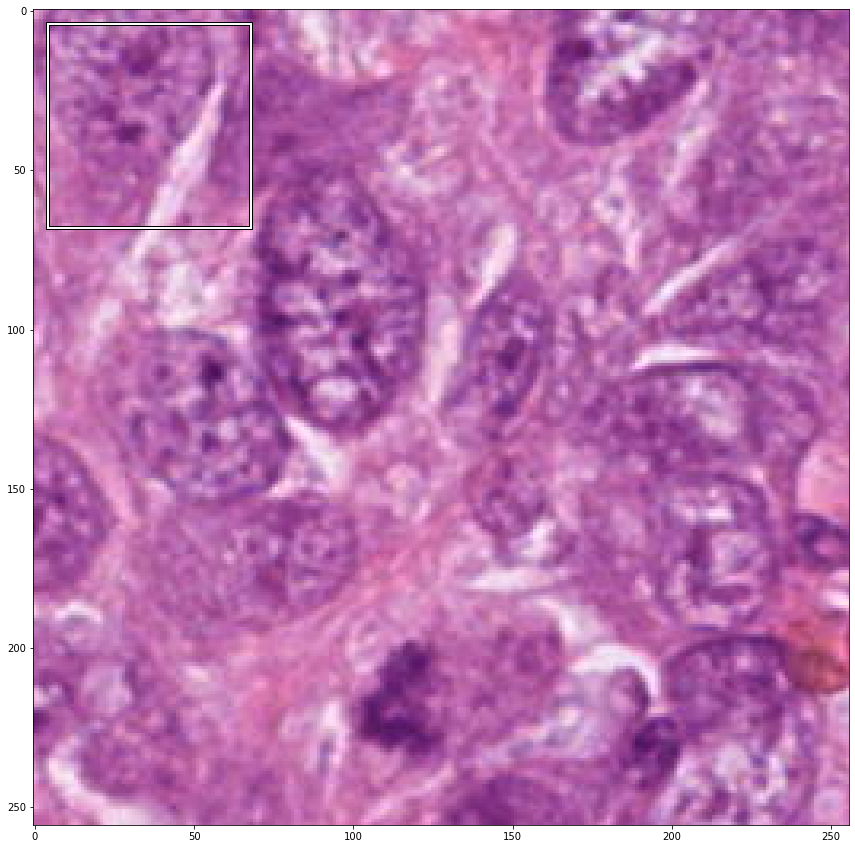

In [21]:
#title For good object detection performance, having good anchor scale ratios, with width to height ratio and feature map sizes is crucial.
#markdown If you have not worked with object detection before, we recommend to have a detailed look at the paper referenced previously to understand the role of these parameters.
#markdown
#markdown Scales: What dimension an anchor can be compared to the feature map box size. Example values are [0.5, 1, 1.5].
scales = [2] #param {type:"raw"}

#markdown Ratios: Well, that is easy. Mitotic figures are quadratic, so one is perfect
ratios=[1]  #param {type:"raw"}

#markdown Sizes: The feature map sizes. Available options are [(64,64), (32,32) , (16,16), (8,8), (4,4)] bigger numbers lead to a narrower perception field.   
sizes=[(32,32)] #param {type:"raw"}

anchors = create_anchors(sizes=sizes, ratios=ratios, scales=scales)


fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:len(scales)*len(ratios)*len(sizes)]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * patch_size / 2 
    y = (bb[1] + 1) * patch_size / 2 
    w = bb[2] * patch_size / 2
    h = bb[3] * patch_size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)


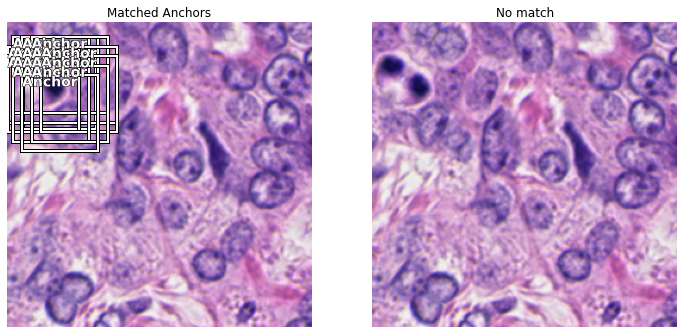

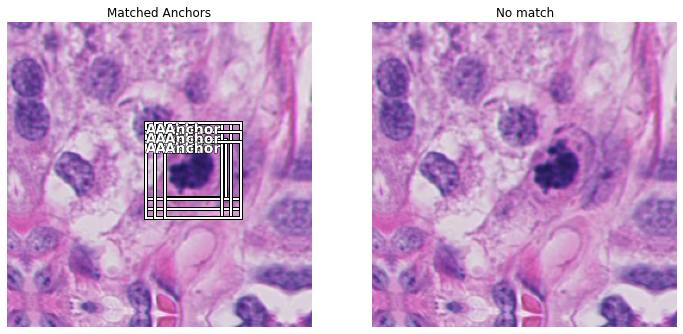

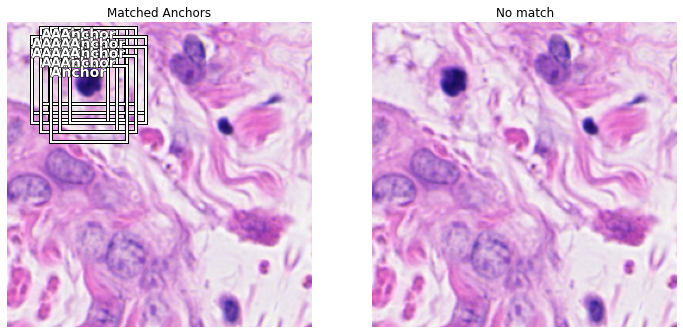

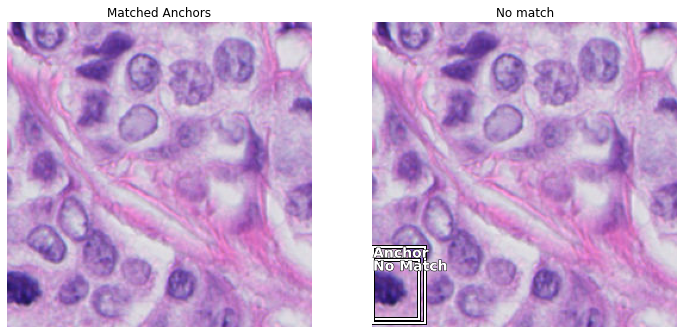

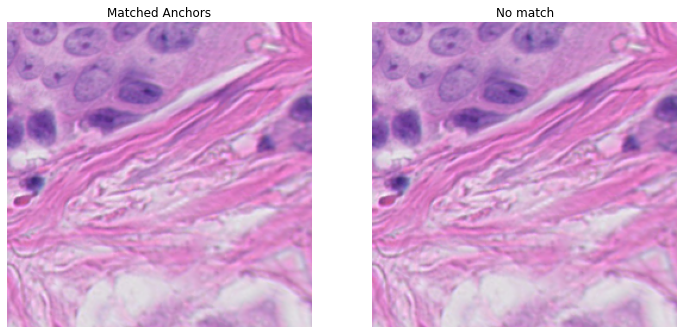

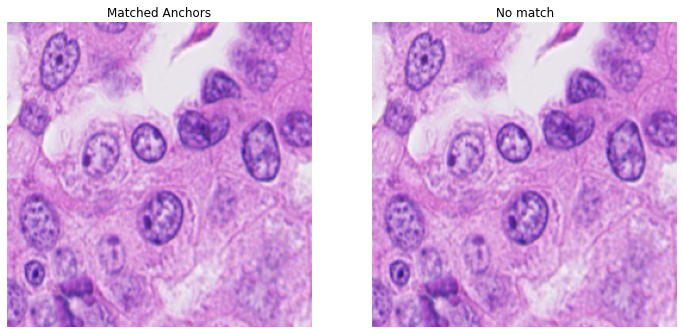

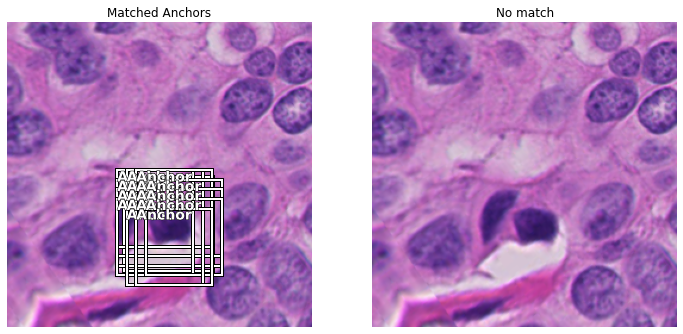

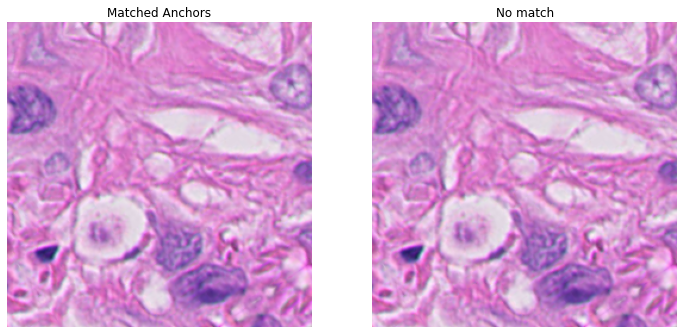

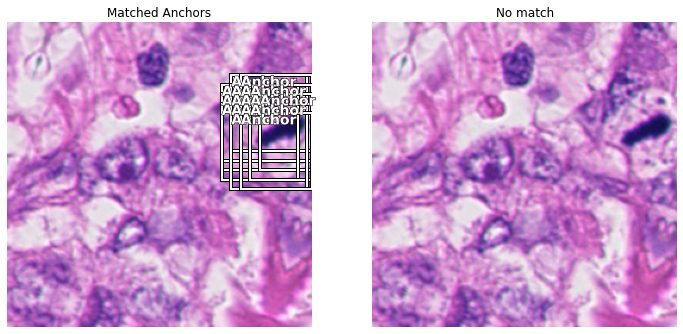

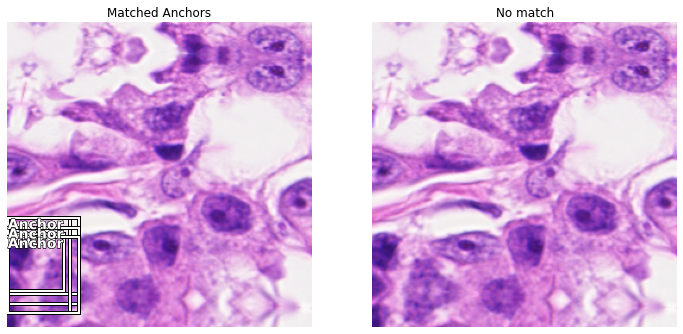

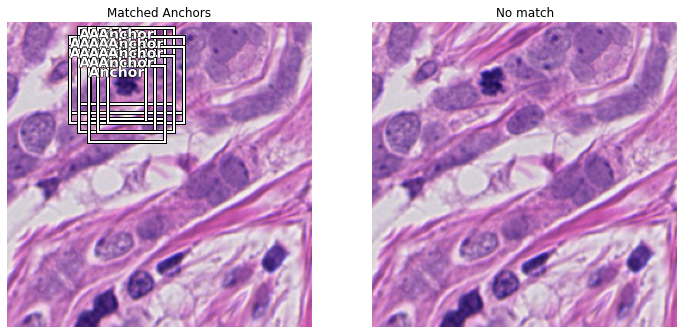

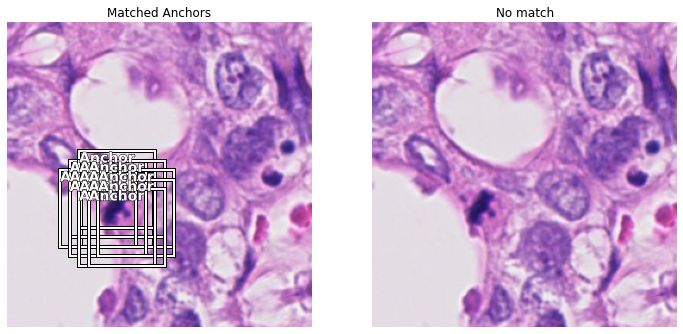

In [22]:
#title Let's validate that our assumptions are correct and the anchors match the boxes

#markdown **Explanation**: Bounding boxes should surround the mitotic figures on the right. If so, the anchors match the size of the bounding boxes. If not, please adjust the parameters above.
all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(12, 12))

## Training an object detection model
After we have set up these necessary prerequisites w.r.t. our training data, let's get the model itself ready for training.

In [23]:
#title Please verify that a GPU is available. { vertical-output: true, display-mode: "form" }

#markdown === Hardware === 

#markdown torch devices : 1

#markdown - gpu0      : NVIDIA GeForce 1070  <-- Important

#markdown === 

#markdown 
#markdown If not, please activate the GPU supported at Google Colab:

#markdown -> Runtime -> Change Runtime Type -> GPU

from fastai.utils.collect_env import show_install
show_install()



```text
=== Software === 
python        : 3.7.13
fastai        : 1.0.61
fastprogress  : 1.0.2
torch         : 1.10.0+cu111
nvidia driver : 460.32
torch cuda    : 11.1 / is available
torch cudnn   : 8005 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Tue Dec 7 09:58:10 PST 2021
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/content
/env/python
/usr/lib/python37.zip
/usr/lib/python3.7
/usr/lib/python3.7/lib-dynload
/usr/local/lib/python3.7/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.7/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installe

In [24]:
#title Let's create the RetinaNet model with an appropriate encoder (backbone) { run: "auto", display-mode: "form" }

backbone = "ResNet18" #param ["ResNet18", "ResNet34", "ResNet50", "ResNet101", "ResNet150"]

backbone_model = models.resnet18
if backbone == "ResNet34":
    backbone_model = models.resnet34
if backbone == "ResNet50":
    backbone_model = models.resnet50
if backbone == "ResNet101":
    backbone_model = models.resnet101
if backbone == "ResNet150":
    backbone_model = models.resnet150

pre_trained_on_imagenet = True #param {type:"boolean"}
encoder = create_body(models.resnet34, pre_trained_on_imagenet, -2)

# Lossfunction (FocalLoss)
#markdown Loss function
loss_function = "FocalLoss"  #param ["FocalLoss"]

if loss_function == "FocalLoss":
    crit = RetinaNetFocalLoss(anchors)

#markdown Number of channels for the dense layer
channels = 128 #param {type:"integer"}

#markdown Bias for the dense layers
final_bias = -4 #param {type:"number"}

#markdown Number of hidden layers
n_conv = 3 #param {type:"integer"}

model = RetinaNet(encoder, n_classes=data.train_ds.c, 
                  n_anchors=len(scales) * len(ratios), 
                  sizes=[size[0] for size in sizes], 
                  chs=channels, # number of hidden layers for the classification head
                  final_bias=final_bias, # Bias for the fully connected layers
                  n_conv=n_conv # Number of hidden layers
                  )

In [25]:
#title To meassure the performance we use the [PascalVOCMetric](https://github.com/rafaelpadilla/review_object_detection_metrics) { vertical-output: true, display-mode: "form" }

voc = PascalVOCMetric(anchors, patch_size, [str(i) for i in data.train_ds.y.classes[1:]])
voc

PascalVOCMetric
anchors: tensor([[-0.9688, -0.9688,  0.5000,  0.5000],
        [-0.9688, -0.9062,  0.5000,  0.5000],
        [-0.9688, -0.8438,  0.5000,  0.5000],
        ...,
        [ 0.9688,  0.8438,  0.5000,  0.5000],
        [ 0.9688,  0.9062,  0.5000,  0.5000],
        [ 0.9688,  0.9688,  0.5000,  0.5000]])
size: 256
metric_names: ['AP-hard negative', 'AP-mitotic figure']
detect_thresh: 0.3
nms_thresh: 0.3
images_per_batch: -1

In [26]:
"Provides basic training and validation with `Learner`"
from fastai.torch_core import *
from fastai.basic_data import *
from fastai.callback import *
from fastai.data_block import *
from fastai.utils.ipython import gpu_mem_restore
import inspect
from fastprogress.fastprogress import format_time, IN_NOTEBOOK
from time import time
from fastai.sixel import plot_sixel

__all__ = ['HLearner', 'LearnerCallback', 'Recorder', 'RecordOnCPU', 'fit', 'loss_batch', 'train_epoch', 'validate',
           'get_preds', 'load_learner']

defaults.lr = slice(3e-3)
defaults.wd = 1e-2
defaults.extra_callbacks    = None
defaults.extra_callback_fns = None

# def loss_batch(model:nn.Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None,
#                cb_handler:Optional[CallbackHandler]=None)->Tuple[Union[Tensor,int,float,str]]:
#     "Calculate loss and metrics for a batch, call out to callbacks as necessary."
#     cb_handler = ifnone(cb_handler, CallbackHandler())
#     if not is_listy(xb): xb = [xb]
#     if not is_listy(yb): yb = [yb]
#     out = model(*xb)
#     out = cb_handler.on_loss_begin(out)

#     if not loss_func: return to_detach(out), to_detach(yb[0])
#     loss = loss_func(out, *yb)

#     if opt is not None:
#         loss,skip_bwd = cb_handler.on_backward_begin(loss)
#         if not skip_bwd:                     loss.backward()
#         if not cb_handler.on_backward_end(): opt.step()
#         if not cb_handler.on_step_end():     opt.zero_grad()

#     return loss.detach().cpu()
    
def hloss_batch(model:nn.Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None,
               cb_handler:Optional[CallbackHandler]=None, step:bool=False)->Tuple[Union[Tensor,int,float,str]]:
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    cb_handler = ifnone(cb_handler, CallbackHandler())

    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    out = model(*xb)
    out = cb_handler.on_loss_begin(out)

    if not loss_func: return to_detach(out), to_detach(yb[0])
    loss = loss_func(out, *yb)

    grads = None
    
    if opt is not None:
        loss,skip_bwd = cb_handler.on_backward_begin(loss)
        if not skip_bwd:                     loss.backward()
        grads = get_grads(model)
        if not cb_handler.on_step_end():     opt.zero_grad()    
        set_grads(model, grads)
        if not cb_handler.on_backward_end(): opt.step()
        if not cb_handler.on_step_end():     opt.zero_grad()    
        

    return loss.detach().cpu(), grads

def get_preds(model:nn.Module, dl:DataLoader, pbar:Optional[PBar]=None, cb_handler:Optional[CallbackHandler]=None,
              activ:nn.Module=None, loss_func:OptLossFunc=None, n_batch:Optional[int]=None) -> List[Tensor]:
    "Tuple of predictions and targets, and optional losses (if `loss_func`) using `dl`, max batches `n_batch`."
    res = [to_float(torch.cat(o).cpu()) for o in
           zip(*validate(model, dl, cb_handler=cb_handler, pbar=pbar, average=False, n_batch=n_batch))]
    if loss_func is not None:
        with NoneReduceOnCPU(loss_func) as lf: res.append(lf(res[0], res[1]))
    if activ is not None: res[0] = activ(res[0])
    return res

def validate(model:nn.Module, dl:DataLoader, loss_func:OptLossFunc=None, cb_handler:Optional[CallbackHandler]=None,
             pbar:Optional[PBar]=None, average=True, n_batch:Optional[int]=None)->Iterator[Tuple[Union[Tensor,int],...]]:
    "Calculate `loss_func` of `model` on `dl` in evaluation mode."
    model.eval()
    with torch.no_grad():
        val_losses,nums = [],[]
        if cb_handler: cb_handler.set_dl(dl)
        for xb,yb in progress_bar(dl, parent=pbar, leave=(pbar is not None)):
            if cb_handler: xb, yb = cb_handler.on_batch_begin(xb, yb, train=False)
            val_loss = loss_batch(model, xb, yb, loss_func, cb_handler=cb_handler)
            val_losses.append(val_loss)
            if not is_listy(yb): yb = [yb]
            nums.append(first_el(yb).shape[0])
            if cb_handler and cb_handler.on_batch_end(val_losses[-1]): break
            if n_batch and (len(nums)>=n_batch): break
        nums = np.array(nums, dtype=np.float32)
        if average: return (to_np(torch.stack(val_losses)) * nums).sum() / nums.sum()
        else:       return val_losses

def train_epoch(model:nn.Module, dl:DataLoader, opt:optim.Optimizer, loss_func:LossFunction)->None:
    "Simple training of `model` for 1 epoch of `dl` using optim `opt` and loss function `loss_func`."
    model.train()
    for xb,yb in dl:
        loss = loss_func(model(xb), yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

@dataclass
class BasicLearner():
    model:nn.Module
    loss_func:LossFunction
    opt:optim.Optimizer
    data:DataBunch

def hfit(epochs:int, learn:BasicLearner, callbacks:Optional[CallbackList]=None, metrics:OptMetrics=None)->None:
    "Fit the `model` on `data` and learn using `loss_func` and `opt`."
    assert len(learn.data.train_dl) != 0, f"""Your training dataloader is empty, can't train a model.
        Use a smaller batch size (batch size={learn.data.train_dl.batch_size} for {len(learn.data.train_dl.dataset)} elements)."""
    assert len(learn.data_2.train_dl) != 0, f"""Your training dataloader 2 is empty, can't train a model.
        Use a smaller batch size (batch size={learn.data_2.train_dl.batch_size} for {len(learn.data_2.train_dl.dataset)} elements)."""
    cb_handler = CallbackHandler(callbacks, metrics)
    pbar = master_bar(range(epochs))
    cb_handler.on_train_begin(epochs, pbar=pbar, metrics=metrics)

    exception=False
    try:
        for epoch in pbar:
            learn.model.train()
            cb_handler.set_dl(learn.data.train_dl)
            cb_handler.on_epoch_begin()
            
            for xy_1, xy_2 in zip(learn.data.train_dl, learn.data_2.train_dl):
                xb_1, yb_1 = xy_1
                xb_1, yb_1 = cb_handler.on_batch_begin(xb_1, yb_1)
                xb_2, yb_2 = xy_2
                xb_2, yb_2 = cb_handler.on_batch_begin(xb_2, yb_2)
                # print(xb_1, xb_2)
                loss_1, grads_1 = hloss_batch(learn.model, xb_1, yb_1, learn.loss_func, learn.opt, cb_handler, step=False)
                # loss_2, grads_2 = hloss_batch(learn.model, xb_2, yb_2, learn.loss_func, learn.opt, cb_handler, step=False)
                # new_grads = fake_grad([grads_1, grads_2])
                # print(new_grads)
                # set_grads(learn.model, new_grads)
                # learn.opt.step()
                if cb_handler.on_batch_end(loss_1): break

            if not cb_handler.skip_validate and not learn.data.empty_val:
                val_loss = validate(learn.model, learn.data.valid_dl, loss_func=learn.loss_func,
                                       cb_handler=cb_handler, pbar=pbar)
            else: val_loss=None
            if cb_handler.on_epoch_end(val_loss): break
    except Exception as e:
        exception = e
        raise
    finally: cb_handler.on_train_end(exception)

loss_func_name2activ = {'cross_entropy_loss': F.softmax, 'nll_loss': torch.exp, 'poisson_nll_loss': torch.exp,
    'kl_div_loss': torch.exp, 'bce_with_logits_loss': torch.sigmoid, 'cross_entropy': F.softmax,
    'kl_div': torch.exp, 'binary_cross_entropy_with_logits': torch.sigmoid,
}

def _loss_func_name2activ(name:str, axis:int=-1):
    res = loss_func_name2activ[name]
    if res == F.softmax: res = partial(F.softmax, dim=axis)
    return res

def _loss_func2activ(loss_func):
    if getattr(loss_func,'keywords',None):
        if not loss_func.keywords.get('log_input', True): return
    axis = getattr(loss_func, 'axis', -1)
    # flattened loss
    loss_func = getattr(loss_func, 'func', loss_func)
    # could have a partial inside flattened loss! Duplicate on purpose.
    loss_func = getattr(loss_func, 'func', loss_func)
    cls_name = camel2snake(loss_func.__class__.__name__)
    if cls_name == 'mix_up_loss':
        loss_func = loss_func.crit
        cls_name = camel2snake(loss_func.__class__.__name__)
    if cls_name in loss_func_name2activ:
        if cls_name == 'poisson_nll_loss' and (not getattr(loss_func, 'log_input', True)): return
        return _loss_func_name2activ(cls_name, axis)
    if getattr(loss_func,'__name__','') in loss_func_name2activ:
        return _loss_func_name2activ(loss_func.__name__, axis)
    return noop

@dataclass
class HLearner():
    "Trainer for `model` using `data` to minimize `loss_func` with optimizer `opt_func`."
    data:DataBunch
    data_2:DataBunch #hamed
    model:nn.Module
    opt_func:Callable=AdamW
    loss_func:Callable=None
    metrics:Collection[Callable]=None
    true_wd:bool=True
    bn_wd:bool=True
    wd:Floats=defaults.wd
    train_bn:bool=True
    path:str = None
    model_dir:PathOrStr = 'models'
    callback_fns:Collection[Callable]=None
    callbacks:Collection[Callback]=field(default_factory=list)
    layer_groups:Collection[nn.Module]=None
    add_time:bool=True
    silent:bool=None
    def __post_init__(self)->None:
        "Setup path,metrics, callbacks and ensure model directory exists."
        self.path = Path(ifnone(self.path, self.data.path))
        self.path_2 = Path(ifnone(self.path, self.data_2.path)) #hamed
        self.model = self.model.to(self.data.device)
        self.loss_func = self.loss_func or self.data.loss_func
        self.metrics=listify(self.metrics)
        if not self.layer_groups: self.layer_groups = [nn.Sequential(*flatten_model(self.model))]
        self.callbacks = listify(self.callbacks)
        if self.silent is None: self.silent = defaults.silent
        self.callback_fns = [partial(Recorder, add_time=self.add_time, silent=self.silent)] + listify(self.callback_fns)
        if defaults.extra_callbacks is not None: self.callbacks += defaults.extra_callbacks

    def init(self, init): apply_init(self.model, init)

    def _test_writeable_path(self):
        path = self.path/self.model_dir
        try:
            path.mkdir(parents=True, exist_ok=True)
            tmp_file = get_tmp_file(path)
        except OSError as e:
            raise Exception(f"{e}\nCan't write to '{path}', set `learn.model_dir` attribute in Learner to a full libpath path that is writable") from None
        os.remove(tmp_file)

    def lr_range(self, lr:Union[float,slice])->np.ndarray:
        "Build differential learning rates from `lr`."
        if not isinstance(lr,slice): return lr
        if lr.start: res = even_mults(lr.start, lr.stop, len(self.layer_groups))
        else: res = [lr.stop/10]*(len(self.layer_groups)-1) + [lr.stop]
        return np.array(res)

    def fit(self, epochs:int, lr:Union[Floats,slice]=defaults.lr,
            wd:Floats=None, callbacks:Collection[Callback]=None)->None:
        "Fit the model on this learner with `lr` learning rate, `wd` weight decay for `epochs` with `callbacks`."
        lr = self.lr_range(lr)
        if wd is None: wd = self.wd
        if not getattr(self, 'opt', False): self.create_opt(lr, wd)
        else: self.opt.lr,self.opt.wd = lr,wd
        callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_callback_fns)] + listify(callbacks)
        hfit(epochs, self, metrics=self.metrics, callbacks=self.callbacks+callbacks)

    def create_opt(self, lr:Floats, wd:Floats=0.)->None:
        "Create optimizer with `lr` learning rate and `wd` weight decay."
        self.opt = OptimWrapper.create(self.opt_func, lr, self.layer_groups, wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)

    def split(self, split_on:SplitFuncOrIdxList)->None:
        "Split the model at `split_on`."
        if isinstance(split_on,Callable): split_on = split_on(self.model)
        self.layer_groups = split_model(self.model, split_on)
        return self

    def freeze_to(self, n:int)->None:
        "Freeze layers up to layer group `n`."
        if hasattr(self.model, 'reset'): self.model.reset()
        for g in self.layer_groups[:n]:
            for l in g:
                if not self.train_bn or not isinstance(l, bn_types): requires_grad(l, False)
        for g in self.layer_groups[n:]: requires_grad(g, True)
        self.create_opt(defaults.lr)

    def freeze(self)->None:
        "Freeze up to last layer group."
        assert(len(self.layer_groups)>1)
        self.freeze_to(-1)

    def unfreeze(self):
        "Unfreeze entire model."
        self.freeze_to(0)

    def export(self, file:PathLikeOrBinaryStream='export.pkl', destroy=False):
        "Export the state of the `Learner` in `self.path/file`. `file` can be file-like (file or buffer)"
        if rank_distrib(): return # don't save if child proc
        args = ['opt_func', 'loss_func', 'metrics', 'true_wd', 'bn_wd', 'wd', 'train_bn', 'model_dir', 'callback_fns']
        state = {a:getattr(self,a) for a in args}
        state['cb_state'] = {cb.__class__:cb.get_state() for cb in self.callbacks}
        #layer_groups -> need to find a way
        #TO SEE: do we save model structure and weights separately?
        with ModelOnCPU(self.model) as m:
            state['model'] = m
            xtra = dict(normalize=self.data.norm.keywords) if getattr(self.data, 'norm', False) else {}
            state['data'] = self.data.valid_ds.get_state(**xtra)
            state['data_2'] = self.data_2.valid_ds.get_state(**xtra) #hamed
            state['cls'] = self.__class__
            try_save(state, self.path, file)
        if destroy: self.destroy()

    def save(self, file:PathLikeOrBinaryStream=None, return_path:bool=False, with_opt:bool=True):
        "Save model and optimizer state (if `with_opt`) with `file` to `self.model_dir`. `file` can be file-like (file or buffer)"
        if is_pathlike(file): self._test_writeable_path()
        if rank_distrib(): return # don't save if child proc
        target = self.path/self.model_dir/f'{file}.pth' if is_pathlike(file) else file
        if not hasattr(self, 'opt'): with_opt=False
        if not with_opt: state = get_model(self.model).state_dict()
        else: state = {'model': get_model(self.model).state_dict(), 'opt':self.opt.state_dict()}
        torch.save(state, target)
        if return_path: return target

    def dl(self, ds_type:DatasetType=DatasetType.Valid):
        "Return DataLoader for DatasetType `ds_type`."
        return self.data.dl(ds_type)

    def dl_2(self, ds_type:DatasetType=DatasetType.Valid): #hamed
        "Return DataLoader for DatasetType `ds_type`."
        return self.data_2.dl(ds_type)

    def load(self, file:PathLikeOrBinaryStream=None, device:torch.device=None, strict:bool=True,
             with_opt:bool=None, purge:bool=False, remove_module:bool=False)->'HLearner':
        "Load model and optimizer state (if `with_opt`) `file` from `self.model_dir` using `device`. `file` can be file-like (file or buffer)"
        if purge: self.purge(clear_opt=ifnone(with_opt, False))
        if device is None: device = self.data.device
        elif isinstance(device, int): device = torch.device('cuda', device)
        source = self.path/self.model_dir/f'{file}.pth' if is_pathlike(file) else file
        distrib_barrier()
        state = torch.load(source, map_location=device)
        if set(state.keys()) == {'model', 'opt'}:
            model_state = state['model']
            if remove_module: model_state = remove_module_load(model_state)
            get_model(self.model).load_state_dict(model_state, strict=strict)
            if ifnone(with_opt,True):
                if not hasattr(self, 'opt'): self.create_opt(defaults.lr, self.wd)
                try:    self.opt.load_state_dict(state['opt'])
                except: pass
        else:
            if with_opt: warn("Saved filed doesn't contain an optimizer state.")
            if remove_module: state = remove_module_load(state)
            get_model(self.model).load_state_dict(state, strict=strict)
        del state
        gc.collect()
        return self

    def destroy(self):
        "Free the Learner internals, leaving just an empty shell that consumes no memory"

        class ZombieLearner(HLearner):
            msg = "this object has been destroyed"
            def __getattr__(self, item):    print(ZombieLearner.msg); return None
            def destroyed(*args, **kwargs): print(ZombieLearner.msg)

        attrs = [k for k in self.__dict__.keys() if not k.startswith("__")]
        for a in attrs: delattr(self, a)
        # the instance methods can still be called, but will just give a message
        methods = [k for k in dir(self) if not k.startswith("__") and inspect.isroutine(getattr(self, k))]
        for m in methods: setattr(self, m, ZombieLearner.destroyed)
        self.__class__ = ZombieLearner
        gc.collect()
        print("this Learner object self-destroyed - it still exists, but no longer usable")

    def purge(self, clear_opt:bool=True):
        "Purge the `Learner` of all cached attributes to release some GPU memory."
        self._test_writeable_path()
        attrs_all = [k for k in self.__dict__.keys() if not k.startswith("__")]
        attrs_pkl = ['bn_wd', 'callback_fns', 'layer_groups', 'loss_func', 'metrics', 'model',
                     'model_dir', 'opt_func', 'path', 'train_bn', 'true_wd', 'wd']
        # +callbacks: get pickled too, but not directly
        attrs_keep = ['data', 'recorder']
        attrs_del = list(set(attrs_all) - set(attrs_keep))
        state = {a:getattr(self, a) for a in attrs_pkl}
        state['cb_state'] = {cb.__class__:cb.get_state() for cb in self.callbacks}
        if hasattr(self, 'opt'): state['opt'] = self.opt.get_state()

        tmp_file = get_tmp_file(self.path/self.model_dir)
        torch_save(state, open(tmp_file, 'wb'))
        for a in attrs_del: delattr(self, a)
        gc.collect()
        state = torch.load(tmp_file)
        os.remove(tmp_file)

        for a in attrs_pkl: setattr(self, a, state[a])
        cb_state = state.pop('cb_state')
        self.callbacks = [load_callback(c,s, self) for c,s in cb_state.items()]
        if not clear_opt and 'opt' in state:
            try: self.opt = OptimWrapper.load_with_state_and_layer_group(state['opt'], self.layer_groups)
            except: warn("Wasn't able to properly load the optimizer state again.")
        del state
        gc.collect()
        return self

    def get_preds(self, ds_type:DatasetType=DatasetType.Valid, activ:nn.Module=None,
                  with_loss:bool=False, n_batch:Optional[int]=None, pbar:Optional[PBar]=None) -> List[Tensor]:
        "Return predictions and targets on `ds_type` dataset."
        lf = self.loss_func if with_loss else None
        activ = ifnone(activ, _loss_func2activ(self.loss_func))
        if not getattr(self, 'opt', False): self.create_opt(defaults.lr, self.wd)
        callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_callback_fns)] + listify(self.callbacks)
        return get_preds(self.model, self.dl(ds_type), cb_handler=CallbackHandler(callbacks),
                         activ=activ, loss_func=lf, n_batch=n_batch, pbar=pbar)

    def pred_batch(self, ds_type:DatasetType=DatasetType.Valid, batch:Tuple=None, reconstruct:bool=False,
                   with_dropout:bool=False, activ:nn.Module=None) -> List[Tensor]:
        "Return output of the model on one batch from `ds_type` dataset."
        if batch is not None: xb,yb = batch
        else: xb,yb = self.data.one_batch(ds_type, detach=False, denorm=False)
        cb_handler = CallbackHandler(self.callbacks)
        xb,yb = cb_handler.on_batch_begin(xb,yb, train=False)
        activ = ifnone(activ, _loss_func2activ(self.loss_func))
        with torch.no_grad():
            if not with_dropout: preds = loss_batch(self.model.eval(), xb, yb, cb_handler=cb_handler)
            else: preds = loss_batch(self.model.eval().apply(self.apply_dropout), xb, yb, cb_handler=cb_handler)
            res = activ(preds[0])
        if not reconstruct: return res
        res = res.detach().cpu()
        ds = self.dl(ds_type).dataset
        norm = getattr(self.data, 'norm', False)
        if norm and norm.keywords.get('do_y',False):
            res = self.data.denorm(res, do_x=True)
        return [ds.reconstruct(o) for o in res]

    def backward(self, item):
        "Pass `item` through the model and computes the gradient. Useful if `backward_hooks` are attached."
        xb,yb = self.data.one_item(item)
        loss = loss_batch(self.model.eval(), xb, yb, self.loss_func, opt=FakeOptimizer(),
                          cb_handler=CallbackHandler(self.callbacks))
        return loss

    def predict(self, item:ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs):
        "Return predicted class, label and probabilities for `item`."
        batch = self.data.one_item(item)
        res = self.pred_batch(batch=batch, with_dropout=with_dropout)
        raw_pred,x = grab_idx(res,0,batch_first=batch_first),batch[0]
        norm = getattr(self.data,'norm',False)
        if norm:
            x = self.data.denorm(x)
            if norm.keywords.get('do_y',False): raw_pred = self.data.denorm(raw_pred)
        ds = self.data.single_ds
        pred = ds.y.analyze_pred(raw_pred, **kwargs)
        x = ds.x.reconstruct(grab_idx(x, 0))
        y = ds.y.reconstruct(pred, x) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
        return (x, y, pred, raw_pred) if return_x else (y, pred, raw_pred)

    def validate(self, dl=None, callbacks=None, metrics=None):
        "Validate on `dl` with potential `callbacks` and `metrics`."
        dl = ifnone(dl, self.data.valid_dl)
        metrics = ifnone(metrics, self.metrics)
        cb_handler = CallbackHandler(self.callbacks + ifnone(callbacks, []), metrics)
        cb_handler.on_train_begin(1, None, metrics); cb_handler.on_epoch_begin()
        val_metrics = validate(self.model, dl, self.loss_func, cb_handler)
        cb_handler.on_epoch_end(val_metrics)
        return cb_handler.state_dict['last_metrics']

    def show_results(self, ds_type=DatasetType.Valid, rows:int=5, **kwargs):
        "Show `rows` result of predictions on `ds_type` dataset."
        #TODO: get read of has_arg x and split_kwargs_by_func if possible
        #TODO: simplify this and refactor with pred_batch(...reconstruct=True)
        n_items = rows ** 2 if self.data.train_ds.x._square_show_res else rows
        if self.dl(ds_type).batch_size < n_items: n_items = self.dl(ds_type).batch_size
        ds = self.dl(ds_type).dataset
        self.callbacks.append(RecordOnCPU())
        preds = self.pred_batch(ds_type)
        *self.callbacks,rec_cpu = self.callbacks
        x,y = rec_cpu.input,rec_cpu.target
        norm = getattr(self.data,'norm',False)
        if norm:
            x = self.data.denorm(x)
            if norm.keywords.get('do_y',False):
                y     = self.data.denorm(y, do_x=True)
                preds = self.data.denorm(preds, do_x=True)
        analyze_kwargs,kwargs = split_kwargs_by_func(kwargs, ds.y.analyze_pred)
        preds = [ds.y.analyze_pred(grab_idx(preds, i), **analyze_kwargs) for i in range(n_items)]
        xs = [ds.x.reconstruct(grab_idx(x, i)) for i in range(n_items)]
        if has_arg(ds.y.reconstruct, 'x'):
            ys = [ds.y.reconstruct(grab_idx(y, i), x=x) for i,x in enumerate(xs)]
            zs = [ds.y.reconstruct(z, x=x) for z,x in zip(preds,xs)]
        else :
            ys = [ds.y.reconstruct(grab_idx(y, i)) for i in range(n_items)]
            zs = [ds.y.reconstruct(z) for z in preds]
        ds.x.show_xyzs(xs, ys, zs, **kwargs)

    def apply_dropout(self, m):
        "If a module contains 'dropout' in it's name, it will be switched to .train() mode."
        if 'dropout' in m.__class__.__name__.lower(): m.train()

    def predict_with_mc_dropout(self, item:ItemBase, with_dropout:bool=True, n_times=10, **kwargs):
        "Make predictions with dropout turned on for n_times (default 10)."
        return [self.predict(item, with_dropout=with_dropout) for _ in range(n_times)]

class RecordOnCPU(Callback):
    "Store the `input` and `target` going through the model on the CPU."
    def on_batch_begin(self, last_input,last_target,**kwargs):
        self.input,self.target = to_cpu(last_input),to_cpu(last_target)

class LearnerCallback(Callback):
    "Base class for creating callbacks for a `Learner`."
    def __init__(self, learn):
        self._learn = weakref.ref(learn)
        self.exclude,self.not_min = ['_learn'],[]
        setattr(self.learn, self.cb_name, self)

    def __getattr__(self,k): return getattr(self.learn, k)
    def __setstate__(self,data:Any): self.__dict__.update(data)

    @property
    def learn(self) -> HLearner: return self._learn()
    @learn.setter
    def learn(self, learn: HLearner) -> None: self._learn = weakref.ref(learn)

    @property
    def cb_name(self): return camel2snake(self.__class__.__name__)

class Recorder(LearnerCallback):
    "A `LearnerCallback` that records epoch, loss, opt and metric data during training."
    _order=-10
    def __init__(self, learn:HLearner, add_time:bool=True, silent:bool=False):
        super().__init__(learn)
        if not getattr(self.learn, 'opt', False): self.learn.create_opt(defaults.lr, self.learn.wd)
        self.opt = self.learn.opt
        self.train_dl = self.learn.data.train_dl
        self.no_val,self.silent,self.add_time = False,silent,add_time

    def on_train_begin(self, pbar:PBar, metrics_names:Collection[str], **kwargs:Any)->None:
        "Initialize recording status at beginning of training."
        self.pbar = pbar
        self.names = ['epoch', 'train_loss'] if self.no_val else ['epoch', 'train_loss', 'valid_loss']
        self.metrics_names = metrics_names
        if hasattr(self, '_added_met_names'): self.metrics_names += self._added_met_names
        self.names += self.metrics_names
        if self.add_time: self.names.append('time')
        if not self.silent: self.pbar.write(self.names, table=True)
        self.losses,self.val_losses,self.lrs,self.moms,self.metrics,self.nb_batches = [],[],[],[],[],[]

    def on_epoch_begin(self, **kwargs:Any)->None:
        if self.add_time: self.start_epoch = time()

    def on_batch_begin(self, train, **kwargs:Any)->None:
        "Record learning rate and momentum at beginning of batch."
        if train:
            self.lrs.append(self.opt.lr)
            self.moms.append(self.opt.mom)

    def on_backward_begin(self, smooth_loss:Tensor, **kwargs:Any)->None:
        "Record the loss before any other callback has a chance to modify it."
        self.losses.append(smooth_loss)
        if self.pbar is not None and hasattr(self.pbar,'child'):
            self.pbar.child.comment = f'{smooth_loss:.4f}'

    def on_epoch_end(self, epoch:int, num_batch:int, smooth_loss:Tensor,
                     last_metrics:MetricsList, **kwargs:Any)->bool:
        "Save epoch info: num_batch, smooth_loss, metrics."
        self.nb_batches.append(num_batch)
        if last_metrics is not None: self.val_losses.append(last_metrics[0])
        else: last_metrics = [] if self.no_val else [None]
        if len(last_metrics) > 1: self.metrics.append(last_metrics[1:])
        self.format_stats([epoch, smooth_loss] + last_metrics)

    def format_stats(self, stats:TensorOrNumList)->None:
        "Format stats before printing."
        str_stats = []
        for name,stat in zip(self.names,stats):
            str_stats.append('#na#' if stat is None else str(stat) if isinstance(stat, int) else f'{stat:.6f}')
        if self.add_time: str_stats.append(format_time(time() - self.start_epoch))
        if not self.silent: self.pbar.write(str_stats, table=True)

    def add_metric_names(self, names):
        "Add `names` to the inner metric names."
        if hasattr(self, '_added_met_names'): self._added_met_names += names
        else:                                 self._added_met_names  = names

    def plot_lr(self, show_moms=False, skip_start:int=0, skip_end:int=0, return_fig:bool=None)->Optional[plt.Figure]:
        "Plot learning rate, `show_moms` to include momentum."
        lrs = self._split_list(self.lrs, skip_start, skip_end)
        iterations = self._split_list(range_of(self.lrs), skip_start, skip_end)
        if show_moms:
            moms = self._split_list(self.moms, skip_start, skip_end)
            fig, axs = plt.subplots(1,2, figsize=(12,4))
            axs[0].plot(iterations, lrs)
            axs[0].set_xlabel('Iterations')
            axs[0].set_ylabel('Learning Rate')
            axs[1].plot(iterations, moms)
            axs[1].set_xlabel('Iterations')
            axs[1].set_ylabel('Momentum')
        else:
            fig, ax = plt.subplots()
            ax.plot(iterations, lrs)
            ax.set_xlabel('Iterations')
            ax.set_ylabel('Learning Rate')
        if ifnone(return_fig, defaults.return_fig): return fig
        if not IN_NOTEBOOK: plot_sixel(fig)

    @staticmethod
    def smoothen_by_spline(xs, ys, **kwargs):
        xs = np.arange(len(ys))
        spl = scipy.interpolate.UnivariateSpline(xs, ys, **kwargs)
        ys = spl(xs)
        return ys

    def plot(self, skip_start:int=10, skip_end:int=5, suggestion:bool=False, return_fig:bool=None, show_grid:bool=False,
             **kwargs)->Optional[plt.Figure]:
        "Plot learning rate and losses, trimmed between `skip_start` and `skip_end`. Optionally plot and return min gradient"
        lrs = self._split_list(self.lrs, skip_start, skip_end)
        losses = self._split_list(self.losses, skip_start, skip_end)
        losses = [x.item() for x in losses]
        if 'k' in kwargs: losses = self.smoothen_by_spline(lrs, losses, **kwargs)
        fig, ax = plt.subplots(1,1)
        ax.plot(lrs, losses)
        ax.set_ylabel("Loss")
        ax.set_xlabel("Learning Rate")
        ax.set_xscale('log')
        if show_grid: plt.grid(True,which="both",ls="-")
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        if suggestion:
            try: mg = (np.gradient(np.array(losses))).argmin()
            except:
                print("Failed to compute the gradients, there might not be enough points.")
                return
            print(f"Min numerical gradient: {lrs[mg]:.2E}")
            ax.plot(lrs[mg],losses[mg],markersize=10,marker='o',color='red')
            self.min_grad_lr = lrs[mg]
            ml = np.argmin(losses)
            print(f"Min loss divided by 10: {lrs[ml]/10:.2E}")
        if ifnone(return_fig, defaults.return_fig): return fig
        if not IN_NOTEBOOK: plot_sixel(fig)

    def plot_losses(self, skip_start:int=0, skip_end:int=0, return_fig:bool=None, show_grid:bool=False)->Optional[plt.Figure]:
        "Plot training and validation losses."
        fig, ax = plt.subplots(1,1)
        losses = self._split_list(self.losses, skip_start, skip_end)
        iterations = self._split_list(range_of(self.losses), skip_start, skip_end)
        ax.plot(iterations, losses, label='Train')
        val_iter = self._split_list_val(np.cumsum(self.nb_batches), skip_start, skip_end)
        val_losses = self._split_list_val(self.val_losses, skip_start, skip_end)
        ax.plot(val_iter, val_losses, label='Validation')
        plt.grid(show_grid)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Batches processed')
        ax.legend()
        if ifnone(return_fig, defaults.return_fig): return fig
        if not IN_NOTEBOOK: plot_sixel(fig)

    def plot_metrics(self, skip_start:int=0, skip_end:int=0, return_fig:bool=None, show_grid:bool=False)->Optional[plt.Figure]:
        "Plot metrics collected during training."
        assert len(self.metrics) != 0, "There are no metrics to plot."
        fig, axes = plt.subplots(len(self.metrics[0]),1,figsize=(6, 4*len(self.metrics[0])))
        val_iter = self._split_list_val(np.cumsum(self.nb_batches), skip_start, skip_end)
        axes = axes.flatten() if len(self.metrics[0]) != 1 else [axes]
        for i, ax in enumerate(axes):
            values = [met[i] for met in self.metrics]
            values = self._split_list_val(values, skip_start, skip_end)
            ax.plot(val_iter, values)
            plt.grid(show_grid)
            ax.set_ylabel(str(self.metrics_names[i]))
            ax.set_xlabel('Batches processed')
        if ifnone(return_fig, defaults.return_fig): return fig
        if not IN_NOTEBOOK: plot_sixel(fig)

    def _split_list(self, vals:Collection[float], skip_start:int, skip_end:int):
        return vals[skip_start:-skip_end] if skip_end > 0 else vals[skip_start:]

    def _split_list_val(self, vals:Collection[float], skip_start:int, skip_end:int):
        val_iter = np.cumsum(self.nb_batches)
        start_val = (val_iter - skip_start >= 0).nonzero()[0].min()
        end_val = (val_iter[-1] - val_iter - skip_end >= 0).nonzero()[0].max()+1
        return vals[start_val:end_val] if skip_end > 0 else vals[start_val:]

class FakeOptimizer():
    def step(self): pass
    def zero_grad(self): pass

def load_callback(class_func, state, learn:HLearner):
    init_kwargs, others = split_kwargs_by_func(state, class_func.__init__)
    res = class_func(learn, **init_kwargs) if issubclass(class_func, LearnerCallback) else class_func(**init_kwargs)
    for k,v in others.items(): setattr(res, k, v)
    return res

def load_learner(path:PathOrStr, file:PathLikeOrBinaryStream='export.pkl', test:ItemList=None, tfm_y=None, **db_kwargs):
    "Load a `Learner` object saved with `export_state` in `path/file` with empty data, optionally add `test` and load on `cpu`. `file` can be file-like (file or buffer)"
    source = Path(path)/file if is_pathlike(file) else file
    state = torch.load(source, map_location='cpu') if defaults.device == torch.device('cpu') else torch.load(source)
    model = state.pop('model')
    src = LabelLists.load_state(path, state.pop('data'))
    if test is not None: src.add_test(test, tfm_y=tfm_y)
    data = src.databunch(**db_kwargs)
    cb_state = state.pop('cb_state')
    clas_func = state.pop('cls')
    res = clas_func(data, model, **state)
    res.callback_fns = state['callback_fns'] #to avoid duplicates
    res.callbacks = [load_callback(c,s, res) for c,s in cb_state.items()]
    return res

In [27]:
"Provides advanced training extensions to `fastai.basic_train`. Includes half-precision, learning rate finder, mixup, and one-cycle"
from fastai.torch_core import *
from fastai.callback import *
from fastai.callbacks import *
from fastai.basic_data import *
from fastai.basic_train import *

__all__ = ['BnFreeze', 'GradientClipping', 'ShowGraph', 'Interpretation', 'ClassificationInterpretation', 'MultiLabelClassificationInterpretation',
 'fit_one_cycle', 'lr_find', 'one_cycle_scheduler', 'to_fp16', 'to_fp32', 'mixup', 'AccumulateScheduler', 'fit_fc']

def one_cycle_scheduler(lr_max:float, **kwargs:Any)->OneCycleScheduler:
    "Instantiate a `OneCycleScheduler` with `lr_max`."
    return partial(OneCycleScheduler, lr_max=lr_max, **kwargs)

def fit_one_cycle(learn:HLearner, cyc_len:int, max_lr:Union[Floats,slice]=defaults.lr,
                  moms:Tuple[float,float]=(0.95,0.85), div_factor:float=25., pct_start:float=0.3, final_div:float=None,
                  wd:float=None, callbacks:Optional[CallbackList]=None, tot_epochs:int=None, start_epoch:int=None)->None:
    "Fit a model following the 1cycle policy."
    max_lr = learn.lr_range(max_lr)
    callbacks = listify(callbacks)
    callbacks.append(OneCycleScheduler(learn, max_lr, moms=moms, div_factor=div_factor, pct_start=pct_start,
                                       final_div=final_div, tot_epochs=tot_epochs, start_epoch=start_epoch))
    learn.fit(cyc_len, max_lr, wd=wd, callbacks=callbacks)

def fit_fc(learn:HLearner, tot_epochs:int=1, lr:float=defaults.lr,  moms:Tuple[float,float]=(0.95,0.85), start_pct:float=0.72,
                  wd:float=None, callbacks:Optional[CallbackList]=None)->None:
    "Fit a model with Flat Cosine Annealing"
    max_lr = learn.lr_range(lr)
    callbacks = listify(callbacks)
    callbacks.append(FlatCosAnnealScheduler(learn, lr, moms=moms, start_pct=start_pct, tot_epochs=tot_epochs))
    learn.fit(tot_epochs, max_lr, wd=wd, callbacks=callbacks)

def lr_find(learn:HLearner, start_lr:Floats=1e-7, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None):
    "Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges."
    start_lr = learn.lr_range(start_lr)
    start_lr = np.array(start_lr) if is_listy(start_lr) else start_lr
    end_lr = learn.lr_range(end_lr)
    end_lr = np.array(end_lr) if is_listy(end_lr) else end_lr
    cb = LRFinder(learn, start_lr, end_lr, num_it, stop_div)
    epochs = int(np.ceil(num_it/len(learn.data.train_dl))) * (num_distrib() or 1)
    learn.fit(epochs, start_lr, callbacks=[cb], wd=wd)

def to_fp16(learn:HLearner, loss_scale:float=None, max_noskip:int=1000, dynamic:bool=True, clip:float=None,
            flat_master:bool=False, max_scale:float=2**24, loss_fp32:bool=True)->HLearner:
    "Put `learn` in FP16 precision mode."
    learn.to_fp32()
    learn.model = model2half(learn.model)
    learn.data.add_tfm(batch_to_half)
    learn.mp_cb = MixedPrecision(learn, loss_scale=loss_scale, max_noskip=max_noskip, dynamic=dynamic, clip=clip,
                                 flat_master=flat_master, max_scale=max_scale, loss_fp32=loss_fp32)
    learn.callbacks.append(learn.mp_cb)
    return learn

def to_fp32(learn:HLearner):
    "Put `learn` back to FP32 precision mode."
    learn.data.remove_tfm(batch_to_half)
    for cb in learn.callbacks:
        if isinstance(cb, MixedPrecision): learn.callbacks.remove(cb)
    learn.model = learn.model.float()
    return learn

def mixup(learn:HLearner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True) -> HLearner:
    "Add mixup https://arxiv.org/abs/1710.09412 to `learn`."
    learn.callback_fns.append(partial(MixUpCallback, alpha=alpha, stack_x=stack_x, stack_y=stack_y))
    return learn

HLearner.fit_one_cycle = fit_one_cycle
HLearner.lr_find = lr_find
HLearner.to_fp16 = to_fp16
HLearner.to_fp32 = to_fp32
HLearner.mixup = mixup
HLearner.fit_fc = fit_fc

class ShowGraph(LearnerCallback):
    "Update a graph of learner stats and metrics after each epoch."
    def on_epoch_end(self, n_epochs:int, last_metrics:MetricsList, **kwargs)->bool:
        "If we have `last_metrics` plot them in our pbar graph"
        if last_metrics is not None and last_metrics[0] is not None:
            rec = self.learn.recorder
            iters = range_of(rec.losses)
            val_iter = np.array(rec.nb_batches).cumsum()
            x_bounds = (0, (n_epochs - len(rec.nb_batches)) * rec.nb_batches[-1] + len(rec.losses))
            y_bounds = (0, max((max(Tensor(rec.losses)), max(Tensor(rec.val_losses)))))
            rec.pbar.update_graph([(iters, rec.losses), (val_iter, rec.val_losses)], x_bounds, y_bounds)
        return {}

class BnFreeze(LearnerCallback):
    "Freeze moving average statistics in all non-trainable batchnorm layers."
    def on_epoch_begin(self, **kwargs:Any)->None:
        "Put bn layers in eval mode just after `model.train()`."
        set_bn_eval(self.learn.model)

class GradientClipping(LearnerCallback):
    "Gradient clipping during training."
    def __init__(self, learn:HLearner, clip:float = 0.):
        super().__init__(learn)
        self.clip = clip

    def on_backward_end(self, **kwargs):
        "Clip the gradient before the optimizer step."
        if self.clip: nn.utils.clip_grad_norm_(self.learn.model.parameters(), self.clip)

def clip_grad(learn:HLearner, clip:float=0.1)->HLearner:
    "Add gradient clipping of `clip` during training."
    learn.callback_fns.append(partial(GradientClipping, clip=clip))
    return learn
HLearner.clip_grad = clip_grad

class AccumulateScheduler(LearnerCallback):
    "Does accumlated step every nth step by accumulating gradients"

    def __init__(self, learn:HLearner, n_step:int = 1, drop_last:bool = False):
        super().__init__(learn)
        self.n_step,self.drop_last = n_step,drop_last

    def on_train_begin(self, **kwargs):
        "check if loss is reduction"
        if hasattr(self.loss_func, "reduction") and (self.loss_func.reduction != "sum"):
             warn("For better gradients consider 'reduction=sum'")

    def on_epoch_begin(self, **kwargs):
        "init samples and batches, change optimizer"
        self.acc_samples, self.acc_batches = 0., 0.

    def on_batch_begin(self, last_input, last_target, **kwargs):
        "accumulate samples and batches"
        self.acc_samples += last_input.shape[0]
        self.acc_batches += 1

    def on_backward_end(self, **kwargs):
        "accumulated step and reset samples, True will result in no stepping"
        if (self.acc_batches % self.n_step) == 0:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_samples)
            self.acc_samples = 0
        else: return {'skip_step':True, 'skip_zero':True}

    def on_epoch_end(self, **kwargs):
        "step the rest of the accumulated grads if not perfectly divisible"
        for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_samples)
        if not self.drop_last: self.learn.opt.step()
        self.learn.opt.zero_grad()


class Interpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, learn:HLearner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=DatasetType.Valid):
        self.data,self.preds,self.y_true,self.losses,self.ds_type, self.learn = \
                                 learn.data,preds,y_true,losses,ds_type,learn
        self.ds = (self.data.train_ds if ds_type == DatasetType.Train else
                   self.data.test_ds if ds_type == DatasetType.Test else
                   self.data.valid_ds if ds_type == DatasetType.Valid else
                   self.data.single_ds if ds_type == DatasetType.Single else
                   self.data.fix_ds)

    @classmethod
    def from_learner(cls, learn: HLearner,  ds_type:DatasetType=DatasetType.Valid, activ:nn.Module=None):
        "Gets preds, y_true, losses to construct base class from a learner"
        preds_res = learn.get_preds(ds_type=ds_type, activ=activ, with_loss=True)
        return cls(learn, *preds_res)

    def top_losses(self, k:int=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)

    # def top_scores(self, metric:Callable=None, k:int=None, largest=True):
    #     "`k` largest(/smallest) metric scores and indexes, defaulting to all scores (sorted by `largest`)."
    #     self.scores = metric(self.preds, self.y_true)
    #     return self.scores.topk(ifnone(k, len(self.scores)), largest=largest)


class ClassificationInterpretation(Interpretation):
    "Interpretation methods for classification models."
    def __init__(self, learn:HLearner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=DatasetType.Valid):
        super().__init__(learn,preds,y_true,losses,ds_type)
        self.pred_class = self.preds.argmax(dim=1)

    def confusion_matrix(self, slice_size:int=1):
        "Confusion matrix as an `np.ndarray`."
        x=torch.arange(0,self.data.c)
        if slice_size is None: cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        else:
            cm = torch.zeros(self.data.c, self.data.c, dtype=x.dtype)
            for i in range(0, self.y_true.shape[0], slice_size):
                cm_slice = ((self.pred_class[i:i+slice_size]==x[:,None])
                            & (self.y_true[i:i+slice_size]==x[:,None,None])).sum(2)
                torch.add(cm, cm_slice, out=cm)
        return to_np(cm)

    def plot_confusion_matrix(self, normalize:bool=False, title:str='Confusion matrix', cmap:Any="Blues", slice_size:int=1,
                              norm_dec:int=2, plot_txt:bool=True, return_fig:bool=None, **kwargs)->Optional[plt.Figure]:
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        cm = self.confusion_matrix(slice_size=slice_size)
        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(**kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(self.data.c)
        plt.xticks(tick_marks, self.data.y.classes, rotation=90)
        plt.yticks(tick_marks, self.data.y.classes, rotation=0)

        if plot_txt:
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

        ax = fig.gca()
        ax.set_ylim(len(self.data.y.classes)-.5,-.5)
                           
        plt.tight_layout()
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.grid(False)
        if ifnone(return_fig, defaults.return_fig): return fig

    def most_confused(self, min_val:int=1, slice_size:int=1)->Collection[Tuple[str,str,int]]:
        "Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences."
        cm = self.confusion_matrix(slice_size=slice_size)
        np.fill_diagonal(cm, 0)
        res = [(self.data.classes[i],self.data.classes[j],cm[i,j])
                for i,j in zip(*np.where(cm>=min_val))]
        return sorted(res, key=itemgetter(2), reverse=True)


def _learner_interpret(learn:HLearner, ds_type:DatasetType=DatasetType.Valid):
    "Create a `ClassificationInterpretation` object from `learner` on `ds_type` with `tta`."
    return ClassificationInterpretation.from_learner(learn, ds_type=ds_type)
HLearner.interpret = _learner_interpret

class MultiLabelClassificationInterpretation(Interpretation):
    "Interpretation methods for classification models."
    def __init__(self, learn:HLearner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=DatasetType.Valid,
                     sigmoid:bool=True, thresh:float=0.3):
        raise NotImplementedError
        super(MultiLabelClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.pred_class = self.preds.sigmoid(dim=1)>thresh if sigmoid else self.preds>thresh
       

In [28]:
def get_grads(net):
    grads = []
    # for p in self.network.parameters():
    for p in net.parameters():
      try:
        grads.append(p.grad.data.clone().flatten())
      except:
        continue
    # print(grads)
    return torch.cat(grads)

def set_grads(net, new_grads):
    start = 0
    # for k, p in enumerate(self.network.parameters()):
    for k, p in enumerate(net.parameters()):
        dims = p.shape
        end = start + dims.numel()
        # print("new_grads",new_grads.shape)
        try:
          p.grad.data = new_grads[start:end].reshape(dims)
          start = end
        except:
          continue
        

In [29]:
from random import shuffle

def pcgrad(domain_grads):
    """ Projecting conflicting gradients (PCGrad). """
    task_order = list(range(len(domain_grads)))

    # Run tasks in random order
    shuffle(task_order)

    # Initialize task gradients
    grad_pc = [g.clone() for g in domain_grads]

    for i in task_order:

        # Run other tasks
        other_tasks = [j for j in task_order if j != i]

        for j in other_tasks:
            grad_j = domain_grads[j]

            # Compute inner product and check for conflicting gradients
            inner_prod = torch.dot(grad_pc[i], grad_j)
            if inner_prod < 0:
                # Sustract the conflicting component
                grad_pc[i] -= inner_prod / (grad_j ** 2).sum() * grad_j

    # Sum task gradients
    new_grads = torch.stack(grad_pc).sum(0)

    return new_grads

In [30]:
def fake_grad(domain_grads):
  return domain_grads[0]

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:

def gradient_maker(domain_grads, epsilon=0.5, alpha=0.05, alpha_schedule='exp'):
    iters = 100
    dgr = torch.stack((domain_grads))
    number_of_domains, dim = dgr.shape
    #
    g = torch.randn(dim).to(device)
    u_ = torch.zeros(number_of_domains).to(device)
    #
    iter = 0
    while (not torch.abs(torch.min(dgr@g)-epsilon)<=0.001) and (iter < iters):
        u_ = u_ + alpha*(epsilon - (dgr@g))
        g = (1./number_of_domains)*torch.sum(((1+(u_>=0)*u_).reshape(number_of_domains, 1))*dgr, axis=0)
        iter = iter + 1
    return g

In [33]:
#title ## Create the FastAI Learner object
learn = HLearner(data=data, model=model, data_2=data_2, loss_func=crit, 
                callback_fns=[BBMetrics, ShowGraph], 
                metrics=[voc]
               )

learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [34]:
# learn = Learner(data=data, model=model, loss_func=crit, 
#                 callback_fns=[BBMetrics, ShowGraph], 
#                 metrics=[voc]
#                )

# learn.split([model.encoder[6], model.c5top5])
# learn.freeze_to(-2)

In [ ]:
# title Find an optimal learning rate. This may take some time. { vertical-output: true, display-mode: "form" }
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

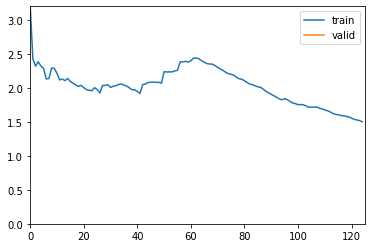

In [36]:
#title Start training with a frozen backbone { run: "auto", vertical-output: true, display-mode: "form" }

#markdown For a background in [transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) and frozen layers please have a look at the [FastAi](https://docs.fast.ai/learner.html#Transfer-learning) documentation.

cyc_len = 1 #param {type:"integer"}
max_learning_rate = 1e-3 #param {type:"number"}

learn.fit_one_cycle(cyc_len, max_learning_rate)

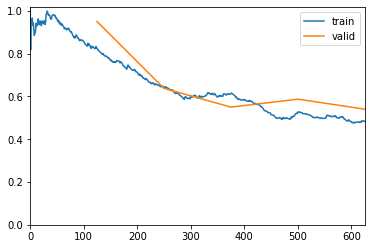

In [37]:
#title Continue training with an unfrozen backbone { run: "auto", vertical-output: true, display-mode: "form" }

cyc_len = 5 #param {type:"integer"}
max_learning_rate = 1e-4 #param {type:"number"}

learn.unfreeze()
learn.fit_one_cycle(cyc_len, max_learning_rate)

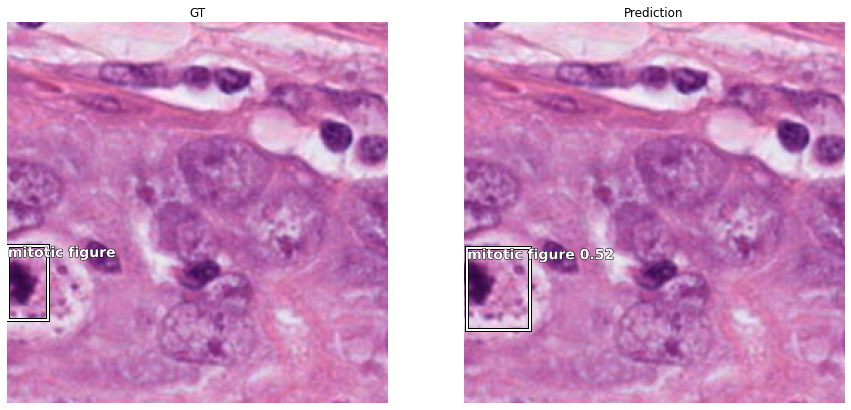

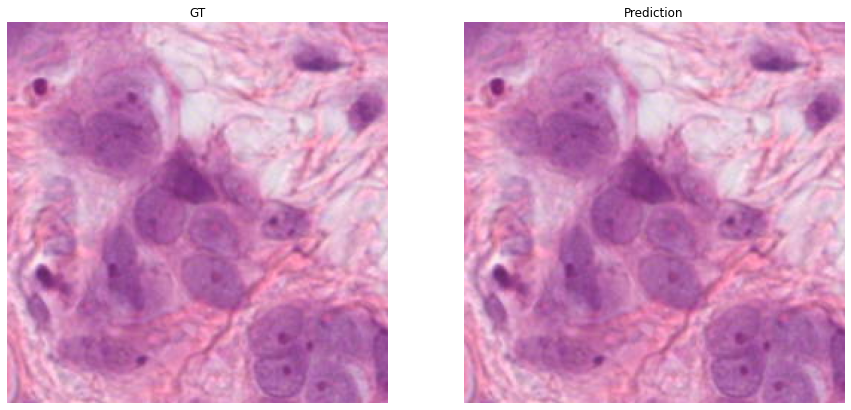

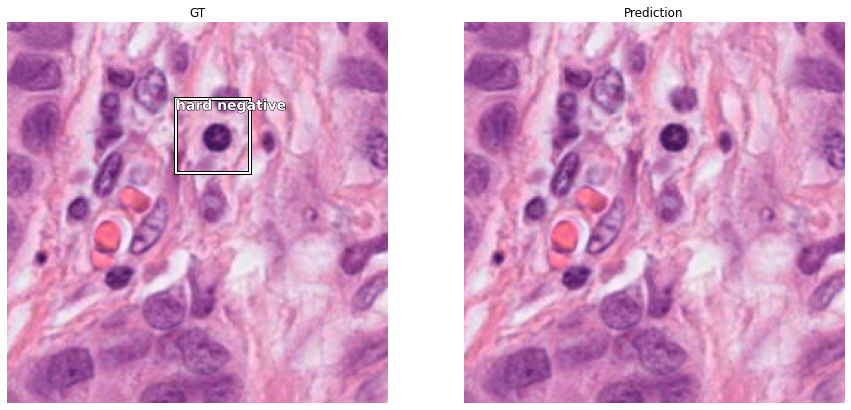

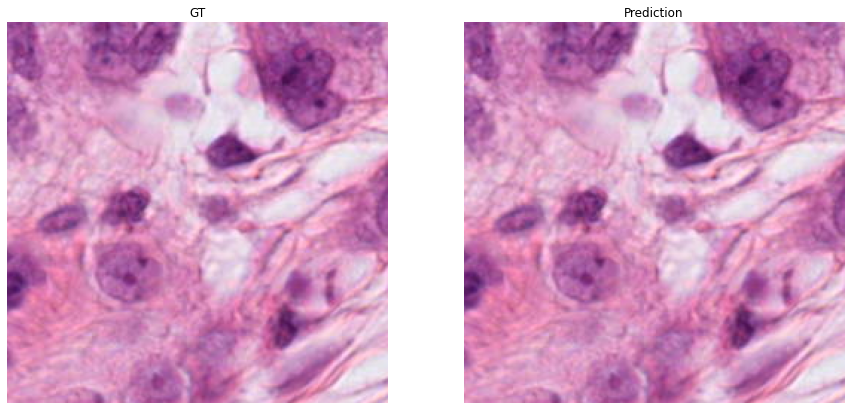

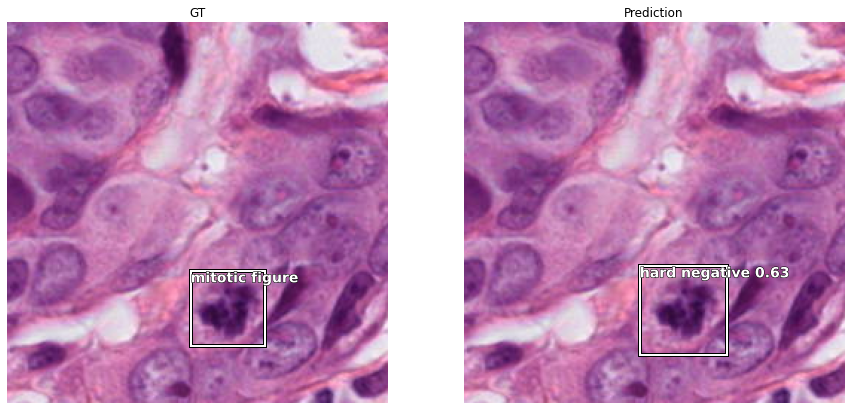

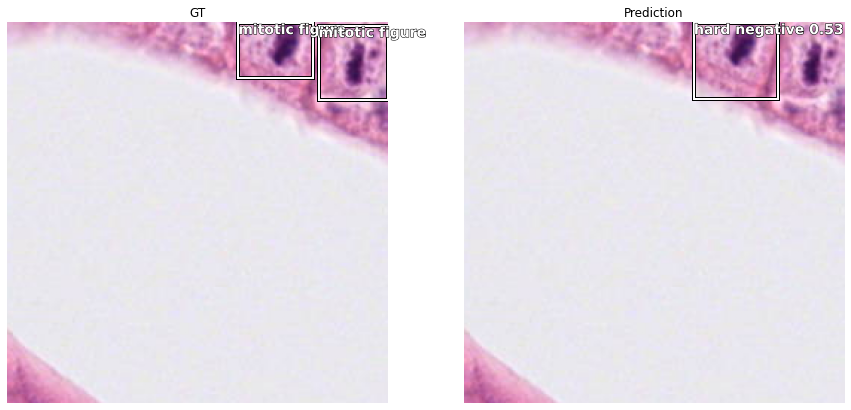

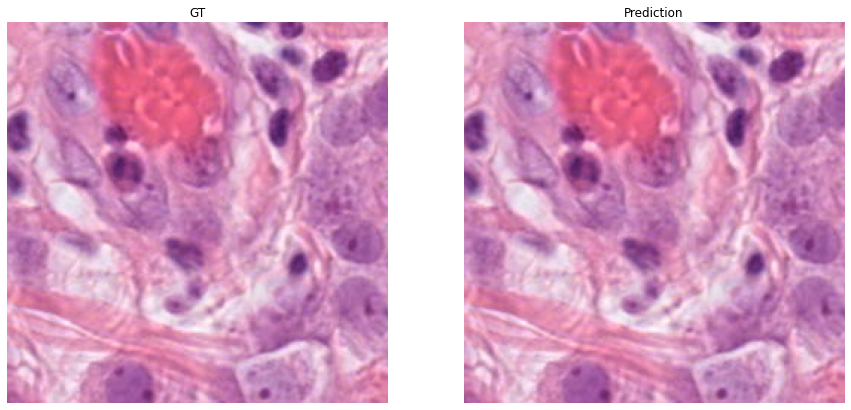

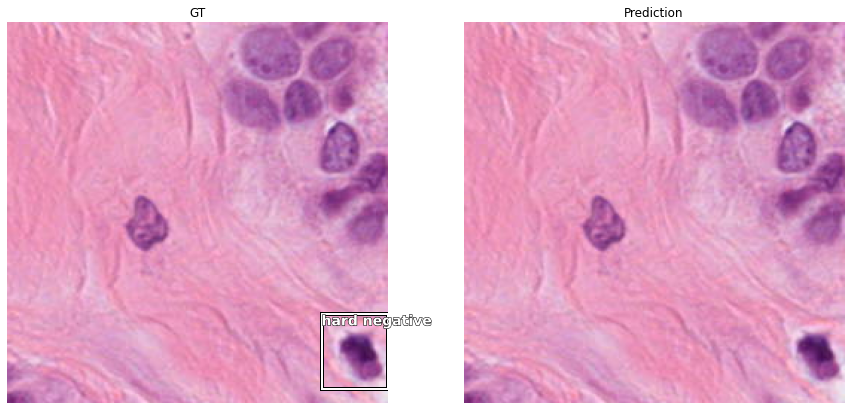

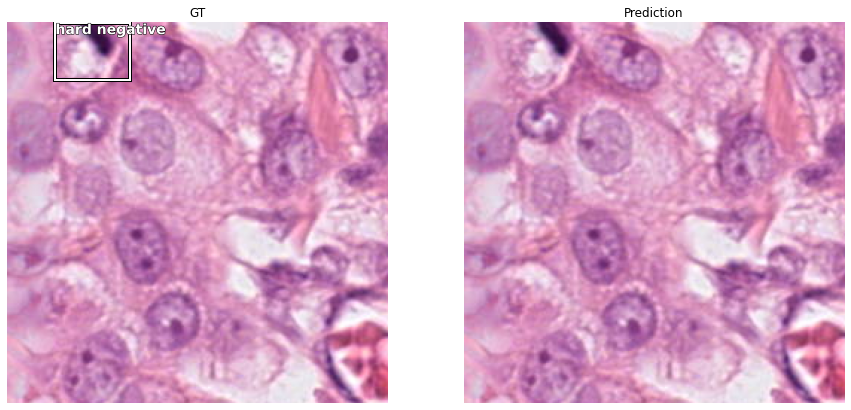

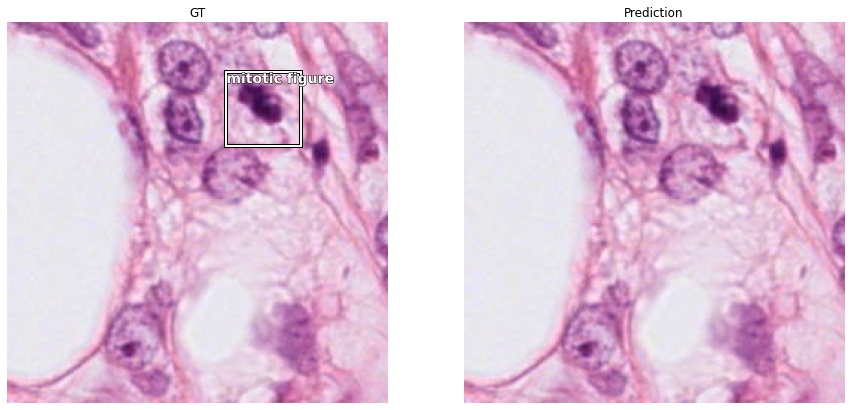

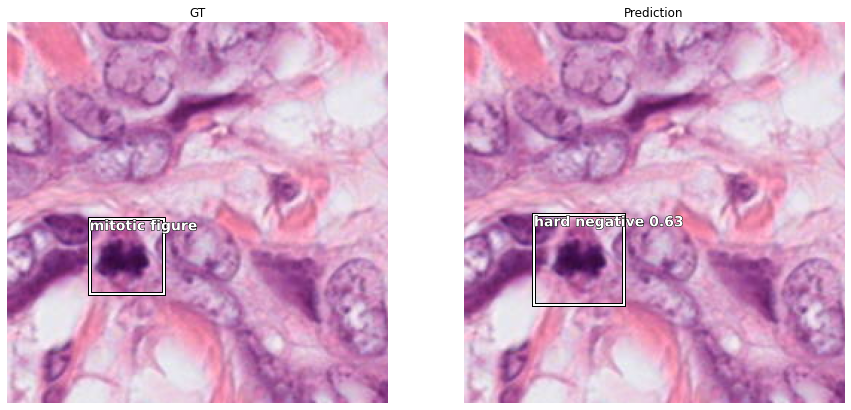

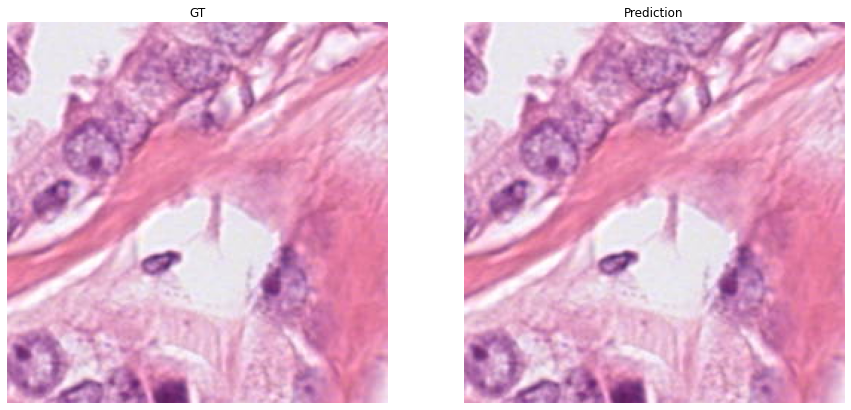

In [38]:
#title Take a look a the results { run: "auto", vertical-output: true, display-mode: "form" }

detect_thresh = 0.5 #param {type:"slider", min:0.1, max:1, step:0.1}
nms_thresh = 0.2 #param {type:"slider", min:0.1, max:1, step:0.1}
image_count=15 #param {type:"integer"}

show_results_side_by_side(learn, anchors, detect_thresh=detect_thresh, nms_thresh=nms_thresh, image_count=image_count)

Please have in mind that the scanners of the test set are partially the same scanners of the training set, and partially different ones.

**We hope that you're now eager to work on the problem and participate in the 
challenge!**

We are looking forward to your clever solutions. See you on **MICCAI 2021**!

**The MIDOG 2021 team**

https://imi.thi.de/midog/